<a href="https://colab.research.google.com/github/devu-13here/Tweet_Emotion_Recognition/blob/main/Tweet_Emotion_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Task 1** Import Libraries

In [141]:
!pip install nlp

In [142]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random

In [143]:
def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(range(epochs_trained), h.history.get('accuracy', []), label='Training Accuracy')
    plt.plot(range(epochs_trained), h.history.get('val_accuracy', []), label='Validation Accuracy')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over Epochs')
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(range(epochs_trained), h.history.get('loss', []), label='Training Loss')
    plt.plot(range(epochs_trained), h.history.get('val_loss', []), label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [144]:
def show_confusion_matrix(y_true,y_pred,classes):
  from sklearn.metrics import confusion_matrix

  cm = confusion_matrix(y_true,y_pred,normalize='true')

  plt.figure(figsize=(8,8))
  sp = plt.subplot(1,1,1)
  ctx = sp.matshow(cm)
  plt.xticks(list(range(0,len(classes))),labels=classes)
  plt.yticks(list(range(0,len(classes))),labels=classes)
  plt.colorbar(ctx)
  plt.show()

print('Using Tensorflow version' , tf.__version__)
print('Using Keras version' , tf.keras.__version__)

Using Tensorflow version 2.17.0
Using Keras version 3.4.1


**Task 2** Importing Data

In [145]:
# Install the datasets library (no need for !pip install nlp, use datasets instead)
!pip install datasets

# Upgrade pyarrow if needed
!pip install --upgrade pyarrow

# Import the datasets library and load the emotion dataset
from datasets import load_dataset

# Load the emotion dataset
dataset = load_dataset('emotion')


In [146]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [147]:
train = dataset['train']
val = dataset['validation']
test = dataset['test']

# Function to get tweets and decode labels
def get_tweet(data):
    tweets = [x['text'] for x in data]
    # Decode the labels using the dataset's features
    labels = [dataset['train'].features['label'].int2str(x['label']) for x in data]
    return tweets, labels

In [148]:
tweets , labels = get_tweet(train)

In [149]:
for i in range(5):
  print(f"('{tweets[i]}','{labels[i]}')")

('i didnt feel humiliated','sadness')
('i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake','sadness')
('im grabbing a minute to post i feel greedy wrong','anger')
('i am ever feeling nostalgic about the fireplace i will know that it is still on the property','love')
('i am feeling grouchy','anger')


In [150]:
tweets[1] , labels[1]

('i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
 'sadness')

**Task 3** Tokenisation

1. Tokenising the tweets.

In [151]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [152]:
tokenizer = Tokenizer(num_words=10000,oov_token='<UNK>')
tokenizer.fit_on_texts(tweets)

In [153]:
tokenizer.texts_to_sequences([tweets[0]])

[[2, 139, 3, 679]]

In [154]:
print(tweets[1])
tokenizer.texts_to_sequences([tweets[1]])

i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake


[[2,
  40,
  101,
  60,
  8,
  15,
  494,
  5,
  15,
  3496,
  553,
  32,
  60,
  61,
  128,
  148,
  76,
  1480,
  4,
  22,
  1255]]

**Task 4** Padding and Truncating

1. Checking length of the tweets
2. Creating padded sequences

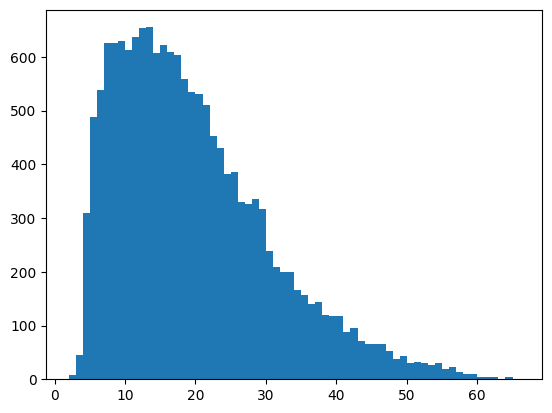

64


In [155]:
lengths = [len(t.split(' ')) for t in tweets]
plt.hist(lengths , bins = len(set(lengths)))
plt.show()
print(len(set(lengths)))

In [156]:
maxlen = 50

from tensorflow.keras.preprocessing.sequence import pad_sequences

In [157]:
def get_sequences(tokenisers , tweets ):
  sequences = tokenisers.texts_to_sequences(tweets)
  padded_sequences = pad_sequences(sequences , truncating='post' , maxlen=maxlen , padding='post')
  return padded_sequences

In [158]:
padded_train_seq = get_sequences(tokenizer,tweets)

In [159]:
padded_train_seq[0]

array([  2, 139,   3, 679,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

**Task 5** Preparing the Labels

1.Creating classes to index and index to classes dictionary.

2.Converting text labels to numeric labels.

In [160]:
classes = set(labels)
print(classes)
#We have 6 different classes these represents 6 different emotions.

{'anger', 'joy', 'fear', 'sadness', 'love', 'surprise'}


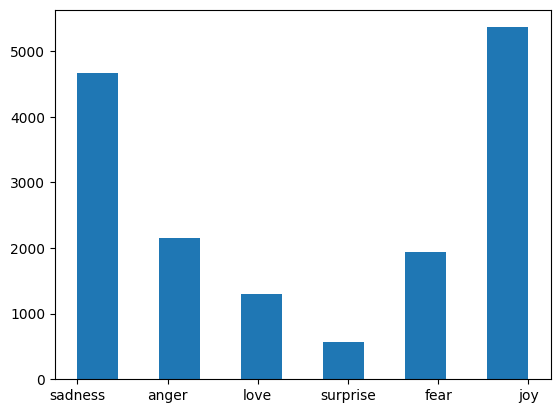

In [161]:
plt.hist(labels , bins=11)
plt.show()

In [162]:
classes_to_index = dict((c,i) for i,c in enumerate(classes))
index_to_classes = dict((v,k) for k,v in classes_to_index.items())

In [163]:
classes_to_index

{'anger': 0, 'joy': 1, 'fear': 2, 'sadness': 3, 'love': 4, 'surprise': 5}

In [164]:
index_to_classes

{0: 'anger', 1: 'joy', 2: 'fear', 3: 'sadness', 4: 'love', 5: 'surprise'}

In [165]:
names_to_idexes = lambda labels: np.array([classes_to_index.get(x) for x in labels])

In [166]:
train_labels = names_to_idexes(labels)
print(train_labels)
print(train_labels[0])
print(train_labels[1])
print(train_labels[2])
print(train_labels[3])
print(train_labels[4])

[3 3 0 ... 1 0 3]
3
3
0
4
0


**Text 6** Creating the Model

1. Creating the model
2. Compiling the model

In [167]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(10000,16,input_length=maxlen),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20,return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
    tf.keras.layers.Dense(6,activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [168]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_8 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_9 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

**Task 7** Training the Model

1. Preparing a validation set
2. Training the model

In [169]:
val_tweets, val_labels = get_tweet(val)
val_seq = get_sequences(tokenizer,val_tweets)
val_labels = names_to_idexes(val_labels)


In [170]:
val_tweets[0] , val_labels[0]

('im feeling quite sad and sorry for myself but ill snap out of it soon', 3)

In [171]:
h = model.fit(padded_train_seq,train_labels,validation_data=(val_seq,val_labels),
              epochs=20,
              callbacks=[
    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=2)
])

Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 25s 34ms/step - accuracy: 0.3599 - loss: 1.5478 - val_accuracy: 0.7085 - val_loss: 0.8533
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.7789 - loss: 0.6693 - val_accuracy: 0.8355 - val_loss: 0.5159
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.9093 - loss: 0.3066 - val_accuracy: 0.8725 - val_loss: 0.3925
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.9502 - loss: 0.1785 - val_accuracy: 0.8840 - val_loss: 0.3609
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.9557 - loss: 0.1536 - val_accuracy: 0.8820 - val_loss: 0.3615
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.9729 - loss: 0.0908 - val_accuracy: 0.8895 - val_loss: 0.3798
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.9761 - loss: 0.0761 - val_accuracy: 0.8780 - val_loss: 0.3908
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.9750 - loss: 0.0816 - val_a

**Task 8** Evaluating the Model

1. Visualizing training history
2. Preparing a test set
3. A look at individual predictions on the test set
4. A look at all predictions on the test set

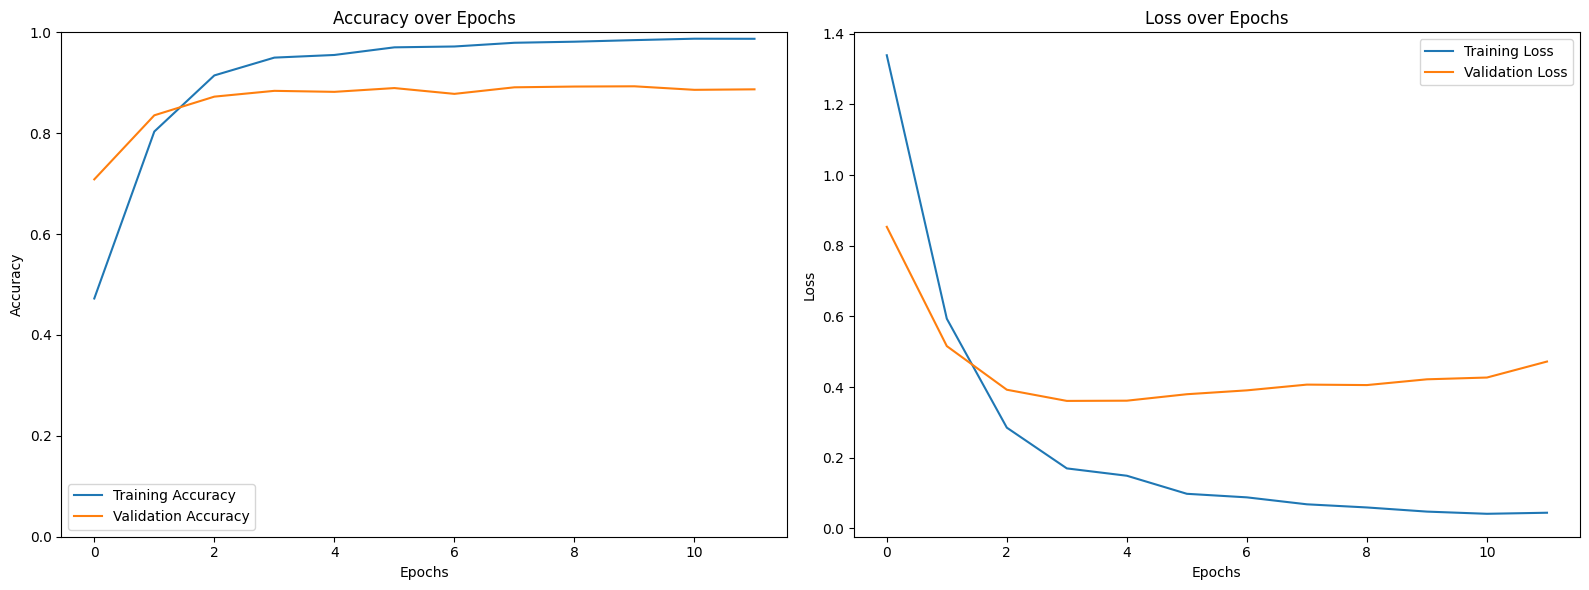

In [172]:
show_history(h)

In [173]:
test_tweets, test_labels = get_tweet(test)
test_sequences = get_sequences(tokenizer, test_tweets)
test_labels = names_to_idexes(test_labels)

In [174]:
model1 = model.evaluate(x = test_sequences, y = test_labels)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8641 - loss: 0.5295


In [175]:
print(type(model1))

<class 'keras.src.models.sequential.Sequential'>


In [176]:
# Ensure these variables are correctly defined:
# test_labels, test_tweets, index_to_class, model, test_sequences

# Randomly select an index
i = random.randint(0, len(test_labels) - 1)

# Print the tweet and its actual emotion
print(f'Tweet: {test_tweets[i]}')
print(f'Emotion: {index_to_classes[test_labels[i]]}')

# Make a prediction for the selected tweet
i_prediction = model.predict(np.expand_dims(test_sequences[i], axis=0))

# Determine the predicted class
predicted_class = index_to_classes[np.argmax(i_prediction).astype('uint8')]

# Print the tweet and its predicted emotion
print(f'\nTweet: {test_tweets[i]}')
print(f'Predicted Emotion: {predicted_class}')


Tweet: i can imagine most young people might feel resentful about the attention their sibling was getting while also feeling guilt at the same time
Emotion: anger
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step

Tweet: i can imagine most young people might feel resentful about the attention their sibling was getting while also feeling guilt at the same time
Predicted Emotion: anger


In [177]:
predictions = model.predict(test_sequences)
predicted_classes = np.argmax(predictions, axis=1)

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


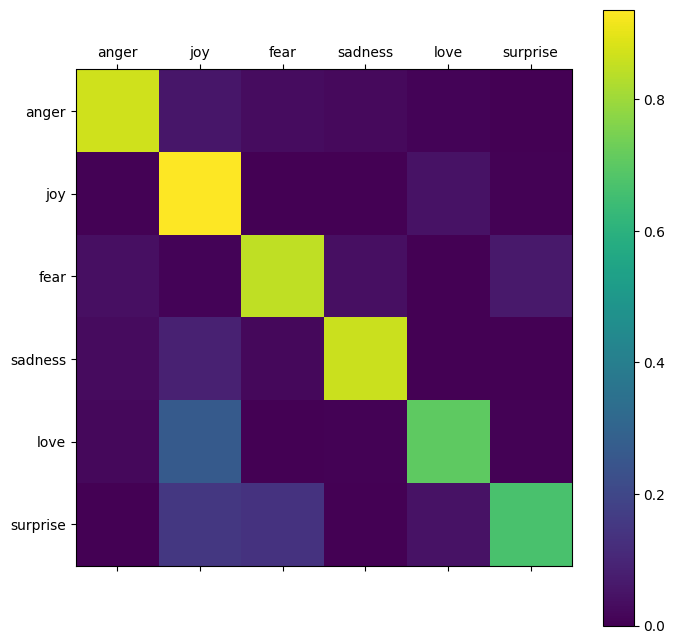

In [178]:
show_confusion_matrix(test_labels, predicted_classes, list(classes))